In [225]:
! pip install tensorflow
! pip install keras
! pip install np_utils

  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=4d98495e7bf37fdc722040d6073cb51ce9970bf32be50da7d6a7b79695b76077
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\57\18\82\402fcaf521e84dfa67b077aea34d225fc32ce6085e2cb8dda6
Successfully built np-utils


In [286]:
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, classification_report, log_loss
from math import sqrt

from sklearn.datasets import make_regression
from keras.models import Sequential
from keras.layers import Dense

from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor
from numpy import argmax
from tensorflow.keras import layers
import tensorflow.compat.v1 as tf
from keras.optimizers import SGD

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from datetime import datetime

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})



# **Load the data**

In [110]:
walk_Acc = pd.read_excel('Walking_Acceleration.xlsx',sheet_name='Sheet1')
walk_AngV = pd.read_excel('Walking_AngularVelo.xlsx',sheet_name='Sheet1')
walk_Mag = pd.read_excel('Walking_MagneticField.xlsx',sheet_name='Sheet1')
walk_Orin = pd.read_excel('Walking_Orientation.xlsx',sheet_name='Sheet1')

In [111]:
walk_Acc.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z
0,2021-01-06 16:27:14.339,-0.828527,6.819369,6.082751
1,2021-01-06 16:27:14.439,-0.869392,7.109765,5.741461
2,2021-01-06 16:27:14.539,-0.476609,7.713609,6.197412
3,2021-01-06 16:27:14.640,-0.544268,7.611522,5.239105
4,2021-01-06 16:27:14.740,-0.925226,7.606432,5.177883


In [112]:
walk_Orin.head()

,Timestamp,Orin_X,Orin_Y,Orin_Z
0,2021-01-06 16:27:14.327,-84.940848,-43.786046,12.547262
1,2021-01-06 16:27:14.428,-83.675170,-44.410081,12.405552
2,2021-01-06 16:27:14.528,-83.621673,-43.114060,10.706334
3,2021-01-06 16:27:14.628,-82.318736,-43.057608,9.723761
4,2021-01-06 16:27:14.729,-79.091831,-42.420334,10.044659


In [113]:
#Drop the timestamp for angular velocity, magnetic field and orientation
walk_AngV= walk_AngV.drop('Timestamp',axis=1)
walk_Mag = walk_Mag.drop('Timestamp',axis=1)
walk_Orin = walk_Orin.drop('Timestamp',axis=1)

In [114]:
#Combine the four frames for the walking activity 
frames = [walk_Acc,walk_AngV,walk_Mag,walk_Orin]

walking_activty = pd.concat(frames,axis=1)

In [115]:
walking_activty.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z
0,2021-01-06 16:27:14.339,-0.828527,6.819369,6.082751,0.106861,-0.136901,-0.028743,18.799908,-40.172142,-14.525543,-84.940848,-43.786046,12.547262
1,2021-01-06 16:27:14.439,-0.869392,7.109765,5.741461,0.208681,-0.095884,-0.132885,19.325588,-40.458717,-14.346252,-83.675170,-44.410081,12.405552
2,2021-01-06 16:27:14.539,-0.476609,7.713609,6.197412,-0.122333,-0.185085,-0.109850,19.180923,-39.644440,-15.834106,-83.621673,-43.114060,10.706334
3,2021-01-06 16:27:14.640,-0.544268,7.611522,5.239105,-0.094719,-0.334172,-0.025198,19.579174,-39.599915,-15.627655,-82.318736,-43.057608,9.723761
4,2021-01-06 16:27:14.740,-0.925226,7.606432,5.177883,0.006501,-0.246699,-0.403404,20.842285,-38.593605,-16.728638,-79.091831,-42.420334,10.044659


In [116]:
#Create a column to identify the activity associated with each data entry 
walking_activty['Activity'] = 'Walking'

In [117]:
walking_activty.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
0,2021-01-06 16:27:14.339,-0.828527,6.819369,6.082751,0.106861,-0.136901,-0.028743,18.799908,-40.172142,-14.525543,-84.940848,-43.786046,12.547262,Walking
1,2021-01-06 16:27:14.439,-0.869392,7.109765,5.741461,0.208681,-0.095884,-0.132885,19.325588,-40.458717,-14.346252,-83.675170,-44.410081,12.405552,Walking
2,2021-01-06 16:27:14.539,-0.476609,7.713609,6.197412,-0.122333,-0.185085,-0.109850,19.180923,-39.644440,-15.834106,-83.621673,-43.114060,10.706334,Walking
3,2021-01-06 16:27:14.640,-0.544268,7.611522,5.239105,-0.094719,-0.334172,-0.025198,19.579174,-39.599915,-15.627655,-82.318736,-43.057608,9.723761,Walking
4,2021-01-06 16:27:14.740,-0.925226,7.606432,5.177883,0.006501,-0.246699,-0.403404,20.842285,-38.593605,-16.728638,-79.091831,-42.420334,10.044659,Walking


In [118]:
#Read the dataframes for the other two activities  
jump_Acc = pd.read_excel('jumping_Acceleration.xlsx',sheet_name='Sheet1')
jump_AngV = pd.read_excel('jumping_AngularVelo.xlsx',sheet_name='Sheet1')
jump_Mag = pd.read_excel('jumping_MagneticField.xlsx',sheet_name='Sheet1')
jump_Orin = pd.read_excel('jumping_Orientation.xlsx',sheet_name='Sheet1')

swing_Acc = pd.read_excel('swinging_Acceleration.xlsx',sheet_name='Sheet1')
swing_AngV = pd.read_excel('swinging_AngularVelo.xlsx',sheet_name='Sheet1')
swing_Mag = pd.read_excel('swinging_MagneticField.xlsx',sheet_name='Sheet1')
swing_Orin = pd.read_excel('swinging_Orientation.xlsx',sheet_name='Sheet1')

In [119]:
#Drop the timestamp for angular velocity, magnetic field and orientation
jump_AngV= jump_AngV.drop('Timestamp',axis=1)
jump_Mag = jump_Mag.drop('Timestamp',axis=1)
jump_Orin = jump_Orin.drop('Timestamp',axis=1)

swing_AngV= swing_AngV.drop('Timestamp',axis=1)
swing_Mag = swing_Mag.drop('Timestamp',axis=1)
swing_Orin = swing_Orin.drop('Timestamp',axis=1)

In [120]:
#Combine the four frames for the jumping activity 
frames = [jump_Acc,jump_AngV,jump_Mag,jump_Orin]

jumping_activty = pd.concat(frames,axis=1)

#Create a column to identify the activity associated with each data entry 
jumping_activty['Activity'] = 'Jumping'



In [121]:
jumping_activty.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
0,2021-01-18 03:10:17.712,-2.400109,11.235635,27.114914,0.470151,-0.769948,0.685925,40.746231,-8.926895,-29.064697,-3.784551,-19.569035,8.687493,Jumping
1,2021-01-18 03:10:17.812,-2.994822,1.881438,8.693771,1.316474,-1.372587,0.523931,36.833817,-13.445503,-31.967712,-6.379213,-24.254150,1.663652,Jumping
2,2021-01-18 03:10:17.912,-1.872456,1.377286,1.274450,-1.261428,-0.335415,-1.428197,36.425568,-7.200516,-34.139008,-3.683060,-17.005911,0.542969,Jumping
3,2021-01-18 03:10:18.013,-0.990341,0.905467,3.191064,-0.140698,1.109465,0.508573,38.176628,-10.590744,-32.949890,-7.400469,-18.987877,2.295079,Jumping
4,2021-01-18 03:10:18.113,-0.048499,5.662575,11.842923,1.306028,-1.089200,0.082469,34.691154,-15.021370,-34.592773,-8.083788,-26.002367,-2.843416,Jumping


In [122]:
#Combine the four frames for the swinging activity 
frames = [swing_Acc,swing_AngV,swing_Mag,swing_Orin]

swinging_activty = pd.concat(frames,axis=1)

#Create a column to identify the activity associated with each data entry 
swinging_activty['Activity'] = 'Swinging'

In [123]:
swinging_activty.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
0,2021-01-18 03:01:42.001,-1.919608,7.613767,6.385721,-0.772020,1.488157,1.052777,44.758217,-15.739548,-20.047760,-26.084855,-54.883991,30.678756,Swinging
1,2021-01-18 03:01:42.101,-1.383273,7.758516,6.000422,-0.788911,1.547042,1.405994,46.040775,-20.177544,-15.062927,-41.091620,-54.629243,27.534493,Swinging
2,2021-01-18 03:01:42.202,-0.957110,7.817044,5.486092,0.190912,1.456345,0.888364,46.176483,-24.577888,-7.802246,-48.743380,-57.554273,29.148350,Swinging
3,2021-01-18 03:01:42.302,-1.423091,8.151599,4.455036,-0.303343,1.295684,0.566664,45.512138,-27.457642,-3.227051,-55.495965,-57.787586,30.659183,Swinging
4,2021-01-18 03:01:42.402,-1.316213,8.814121,4.876559,-0.475277,0.752605,0.507588,44.782772,-29.135948,-1.681488,-62.627948,-56.871672,28.689214,Swinging


In [124]:
#Combine the three activities 
all_frames = [walking_activty,jumping_activty,swinging_activty]
all_activities = pd.concat(all_frames,axis=0)

In [125]:
all_activities.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
0,2021-01-06 16:27:14.339,-0.828527,6.819369,6.082751,0.106861,-0.136901,-0.028743,18.799908,-40.172142,-14.525543,-84.940848,-43.786046,12.547262,Walking
1,2021-01-06 16:27:14.439,-0.869392,7.109765,5.741461,0.208681,-0.095884,-0.132885,19.325588,-40.458717,-14.346252,-83.675170,-44.410081,12.405552,Walking
2,2021-01-06 16:27:14.539,-0.476609,7.713609,6.197412,-0.122333,-0.185085,-0.109850,19.180923,-39.644440,-15.834106,-83.621673,-43.114060,10.706334,Walking
3,2021-01-06 16:27:14.640,-0.544268,7.611522,5.239105,-0.094719,-0.334172,-0.025198,19.579174,-39.599915,-15.627655,-82.318736,-43.057608,9.723761,Walking
4,2021-01-06 16:27:14.740,-0.925226,7.606432,5.177883,0.006501,-0.246699,-0.403404,20.842285,-38.593605,-16.728638,-79.091831,-42.420334,10.044659,Walking


In [126]:
all_activities.tail()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
1194,2021-01-18 03:03:41.797,0.586480,7.612420,5.791157,-0.240027,1.385385,0.751482,38.933270,-33.380165,-11.749084,-77.409540,-56.365387,2.816377,Swinging
1195,2021-01-18 03:03:41.898,0.540676,7.835755,6.039940,-0.191880,0.975696,0.581214,38.658539,-35.284271,-9.056702,-83.605465,-55.175201,3.340344,Swinging
1196,2021-01-18 03:03:41.998,0.429158,8.278385,6.185138,-0.230423,0.630938,0.471039,37.147129,-36.570480,-7.211365,-88.220096,-54.183718,3.081541,Swinging
1197,2021-01-18 03:03:42.098,0.039817,8.212223,6.188880,0.055325,0.475389,0.246484,36.607452,-37.595322,-5.351410,-90.182531,-54.473392,3.914885,Swinging
1198,2021-01-18 03:03:42.199,0.688718,7.939190,5.520819,0.342332,0.272735,0.008836,36.655884,-37.913132,-3.691742,-89.800651,-56.203581,5.927406,Swinging


In [127]:
all_activities = all_activities.reset_index()

all_activities.head()

,index,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
0,0,2021-01-06 16:27:14.339,-0.828527,6.819369,6.082751,0.106861,-0.136901,-0.028743,18.799908,-40.172142,-14.525543,-84.940848,-43.786046,12.547262,Walking
1,1,2021-01-06 16:27:14.439,-0.869392,7.109765,5.741461,0.208681,-0.095884,-0.132885,19.325588,-40.458717,-14.346252,-83.675170,-44.410081,12.405552,Walking
2,2,2021-01-06 16:27:14.539,-0.476609,7.713609,6.197412,-0.122333,-0.185085,-0.109850,19.180923,-39.644440,-15.834106,-83.621673,-43.114060,10.706334,Walking
3,3,2021-01-06 16:27:14.640,-0.544268,7.611522,5.239105,-0.094719,-0.334172,-0.025198,19.579174,-39.599915,-15.627655,-82.318736,-43.057608,9.723761,Walking
4,4,2021-01-06 16:27:14.740,-0.925226,7.606432,5.177883,0.006501,-0.246699,-0.403404,20.842285,-38.593605,-16.728638,-79.091831,-42.420334,10.044659,Walking


In [128]:
all_activities.tail()

,index,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
3595,1194,2021-01-18 03:03:41.797,0.586480,7.612420,5.791157,-0.240027,1.385385,0.751482,38.933270,-33.380165,-11.749084,-77.409540,-56.365387,2.816377,Swinging
3596,1195,2021-01-18 03:03:41.898,0.540676,7.835755,6.039940,-0.191880,0.975696,0.581214,38.658539,-35.284271,-9.056702,-83.605465,-55.175201,3.340344,Swinging
3597,1196,2021-01-18 03:03:41.998,0.429158,8.278385,6.185138,-0.230423,0.630938,0.471039,37.147129,-36.570480,-7.211365,-88.220096,-54.183718,3.081541,Swinging
3598,1197,2021-01-18 03:03:42.098,0.039817,8.212223,6.188880,0.055325,0.475389,0.246484,36.607452,-37.595322,-5.351410,-90.182531,-54.473392,3.914885,Swinging
3599,1198,2021-01-18 03:03:42.199,0.688718,7.939190,5.520819,0.342332,0.272735,0.008836,36.655884,-37.913132,-3.691742,-89.800651,-56.203581,5.927406,Swinging


In [129]:
all_activities = all_activities.drop('index',axis=1)


In [130]:
all_activities.tail()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
3595,2021-01-18 03:03:41.797,0.586480,7.612420,5.791157,-0.240027,1.385385,0.751482,38.933270,-33.380165,-11.749084,-77.409540,-56.365387,2.816377,Swinging
3596,2021-01-18 03:03:41.898,0.540676,7.835755,6.039940,-0.191880,0.975696,0.581214,38.658539,-35.284271,-9.056702,-83.605465,-55.175201,3.340344,Swinging
3597,2021-01-18 03:03:41.998,0.429158,8.278385,6.185138,-0.230423,0.630938,0.471039,37.147129,-36.570480,-7.211365,-88.220096,-54.183718,3.081541,Swinging
3598,2021-01-18 03:03:42.098,0.039817,8.212223,6.188880,0.055325,0.475389,0.246484,36.607452,-37.595322,-5.351410,-90.182531,-54.473392,3.914885,Swinging
3599,2021-01-18 03:03:42.199,0.688718,7.939190,5.520819,0.342332,0.272735,0.008836,36.655884,-37.913132,-3.691742,-89.800651,-56.203581,5.927406,Swinging


In [131]:
#Save the dataframe as a csv file 
all_activities.to_csv(r'All_Activities.csv', index=False)

In [132]:
all_activities.tail()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
3595,2021-01-18 03:03:41.797,0.586480,7.612420,5.791157,-0.240027,1.385385,0.751482,38.933270,-33.380165,-11.749084,-77.409540,-56.365387,2.816377,Swinging
3596,2021-01-18 03:03:41.898,0.540676,7.835755,6.039940,-0.191880,0.975696,0.581214,38.658539,-35.284271,-9.056702,-83.605465,-55.175201,3.340344,Swinging
3597,2021-01-18 03:03:41.998,0.429158,8.278385,6.185138,-0.230423,0.630938,0.471039,37.147129,-36.570480,-7.211365,-88.220096,-54.183718,3.081541,Swinging
3598,2021-01-18 03:03:42.098,0.039817,8.212223,6.188880,0.055325,0.475389,0.246484,36.607452,-37.595322,-5.351410,-90.182531,-54.473392,3.914885,Swinging
3599,2021-01-18 03:03:42.199,0.688718,7.939190,5.520819,0.342332,0.272735,0.008836,36.655884,-37.913132,-3.691742,-89.800651,-56.203581,5.927406,Swinging


In [133]:
all_activities.head()

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
0,2021-01-06 16:27:14.339,-0.828527,6.819369,6.082751,0.106861,-0.136901,-0.028743,18.799908,-40.172142,-14.525543,-84.940848,-43.786046,12.547262,Walking
1,2021-01-06 16:27:14.439,-0.869392,7.109765,5.741461,0.208681,-0.095884,-0.132885,19.325588,-40.458717,-14.346252,-83.675170,-44.410081,12.405552,Walking
2,2021-01-06 16:27:14.539,-0.476609,7.713609,6.197412,-0.122333,-0.185085,-0.109850,19.180923,-39.644440,-15.834106,-83.621673,-43.114060,10.706334,Walking
3,2021-01-06 16:27:14.640,-0.544268,7.611522,5.239105,-0.094719,-0.334172,-0.025198,19.579174,-39.599915,-15.627655,-82.318736,-43.057608,9.723761,Walking
4,2021-01-06 16:27:14.740,-0.925226,7.606432,5.177883,0.006501,-0.246699,-0.403404,20.842285,-38.593605,-16.728638,-79.091831,-42.420334,10.044659,Walking


# **Data exploration**

In [224]:
all_activities = pd.read_csv('All_Activities.csv', engine='python')
all_activities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600 entries, 0 to 3599
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  3599 non-null   object 
 1   Acc_X      3599 non-null   float64
 2   Acc_Y      3599 non-null   float64
 3   Acc_Z      3599 non-null   float64
 4   AngV_X     3600 non-null   float64
 5   AngV_Y     3600 non-null   float64
 6   AngV_Z     3600 non-null   float64
 7   Mag_X      3600 non-null   float64
 8   Mag_Y      3600 non-null   float64
 9   Mag_Z      3600 non-null   float64
 10  Orin_X     3600 non-null   float64
 11  Orin_Y     3600 non-null   float64
 12  Orin_Z     3600 non-null   float64
 13  Activity   3600 non-null   int64  
dtypes: float64(12), int64(1), object(1)
memory usage: 393.9+ KB


In [225]:
#Check for null values 
all_activities.isnull().sum()

Timestamp    1
Acc_X        1
Acc_Y        1
Acc_Z        1
AngV_X       0
AngV_Y       0
AngV_Z       0
Mag_X        0
Mag_Y        0
Mag_Z        0
Orin_X       0
Orin_Y       0
Orin_Z       0
Activity     0
dtype: int64

In [226]:
#Visualize the null observations 
all_activities[all_activities['Acc_X'].isnull()]
all_activities[all_activities['Acc_Y'].isnull()]
all_activities[all_activities['Acc_Z'].isnull()]

,Timestamp,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z,Activity
2400,NaN,NaN,NaN,NaN,0.446561,0.254694,-0.094105,26.570484,-1.353706,-21.018097,8.907269,-22.306759,14.425145,1


In [230]:
# Deleting the NULL values
all_activities = all_activities.dropna(subset = ['Acc_X'])
all_activities = all_activities.dropna(subset = ['Acc_Y'])
all_activities = all_activities.dropna(subset = ['Acc_Z'])
all_activities.shape
# Visualize the NULL observations
all_activities.isnull().sum()


Timestamp    0
Acc_X        0
Acc_Y        0
Acc_Z        0
AngV_X       0
AngV_Y       0
AngV_Z       0
Mag_X        0
Mag_Y        0
Mag_Z        0
Orin_X       0
Orin_Y       0
Orin_Z       0
Activity     0
dtype: int64

In [231]:
all_activities.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3599 entries, 0 to 3599
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Timestamp  3599 non-null   object 
 1   Acc_X      3599 non-null   float64
 2   Acc_Y      3599 non-null   float64
 3   Acc_Z      3599 non-null   float64
 4   AngV_X     3599 non-null   float64
 5   AngV_Y     3599 non-null   float64
 6   AngV_Z     3599 non-null   float64
 7   Mag_X      3599 non-null   float64
 8   Mag_Y      3599 non-null   float64
 9   Mag_Z      3599 non-null   float64
 10  Orin_X     3599 non-null   float64
 11  Orin_Y     3599 non-null   float64
 12  Orin_Z     3599 non-null   float64
 13  Activity   3599 non-null   int64  
dtypes: float64(12), int64(1), object(1)
memory usage: 421.8+ KB


In [86]:
#Save the clean data to a csv file
#all_activities.to_csv(r'All_Activities.csv', index=False)

# **Split data**

In [169]:
#def prepare_targets(y_train, y_test):
    #le = LabelEncoder()
    #le.fit(y_train)
    #y_train_enc = le.transform(y_train)
    #y_test_enc = le.transform(y_test)
    #y_valid_enc = le.transform(y_valid)
    #return y_train_enc, y_test_enc, y_valid


In [251]:
# Split the data into X & y
X = all_activities.drop('Activity',axis = 1).values
y = all_activities['Activity']


y= y.to_numpy()
y = y.reshape(3599,1)
print(X.shape)
print(y.shape)



(3599, 13)
(3599, 1)


In [249]:
# Hold-out validation

# first one
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size=0.2, random_state=15)

# Second one
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.9, test_size=0.1, random_state=15)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)



(2591, 12)
(720, 12)
(288, 12)
(2591, 1)
(720, 1)
(288, 1)


In [256]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
y = pd.get_dummies(all_activities.Activity, prefix='label')
print(y.head())

   label_0  label_1  label_2
0        1        0        0
1        1        0        0
2        1        0        0
3        1        0        0
4        1        0        0


# **Data Normalization**

In [268]:
# Normalize X
features = ['Acc_X', 'Acc_Y', 'Acc_Z', 'AngV_X', 'AngV_Y', 'AngV_Z','Mag_X', 'Mag_Y', 'Mag_Z', 'Orin_X', 'Orin_Y', 'Orin_Z']

F = all_activities[features]

def getnorm(F):
   
    #fit scaler on training data
    norm = MinMaxScaler().fit(F)

    #transform training data
    X = norm.transform(F)
    X = pd.DataFrame(X, columns=F.columns.values)

    return X;



In [273]:
#all_activities.describe()
X = getnorm(F);


X.head()
#X.shape


,Acc_X,Acc_Y,Acc_Z,AngV_X,AngV_Y,AngV_Z,Mag_X,Mag_Y,Mag_Z,Orin_X,Orin_Y,Orin_Z
0,0.677760,0.420105,0.285233,0.625068,0.462063,0.455444,0.644040,0.138611,0.450242,0.263886,0.399155,0.593038
1,0.677250,0.426998,0.278894,0.632121,0.464682,0.444623,0.650144,0.135013,0.452311,0.267402,0.393434,0.592531
2,0.682152,0.441331,0.287363,0.609193,0.458986,0.447016,0.648464,0.145237,0.435143,0.267551,0.405316,0.586458
3,0.681308,0.438908,0.269564,0.611106,0.449464,0.455812,0.653088,0.145796,0.437525,0.271171,0.405834,0.582947
4,0.676553,0.438787,0.268427,0.618117,0.455051,0.416514,0.667756,0.158432,0.424822,0.280137,0.411676,0.584094


# **Building the neural network**

In [276]:
def getmodel(n_inputs=4, n_outputs=3, optimizerinput='sgd'):
   
 # create model
    model = Sequential()
    
    model.add(layers.Dense(2000, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(layers.Dense(2000, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))  
    sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


#Code to run Neuralnetwork using for classification
#using model.fit

model=get_nn_simpleClassificationmodel(n_inputs=len(F.columns), n_outputs=3);
history =model.fit(X_train, y_train, verbose=1, epochs=20, batch_size=20, validation_data=(X_valid, y_valid))


# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)

print(loss)
print(acc)

Epoch 1/20
130/130 [==============================] - 9s 70ms/step - loss: 0.8216 - accuracy: 0.6357 - val_loss: 0.7188 - val_accuracy: 0.6146
Epoch 2/20
130/130 [==============================] - 9s 69ms/step - loss: 0.5557 - accuracy: 0.7877 - val_loss: 0.5599 - val_accuracy: 0.7639
Epoch 3/20
130/130 [==============================] - 9s 67ms/step - loss: 0.4406 - accuracy: 0.8398 - val_loss: 0.4187 - val_accuracy: 0.8368
Epoch 4/20
130/130 [==============================] - 9s 67ms/step - loss: 0.3740 - accuracy: 0.8711 - val_loss: 0.3466 - val_accuracy: 0.8819
Epoch 5/20
130/130 [==============================] - 9s 66ms/step - loss: 0.3200 - accuracy: 0.8908 - val_loss: 0.3182 - val_accuracy: 0.9201
Epoch 6/20
130/130 [==============================] - 9s 67ms/step - loss: 0.2764 - accuracy: 0.9143 - val_loss: 0.3933 - val_accuracy: 0.8264
Epoch 7/20
130/130 [==============================] - 9s 66ms/step - loss: 0.2412 - accuracy: 0.9317 - val_loss: 0.2326 - val_accuracy: 0.9340

In [296]:
print('Summary of the results after each epoch:')
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

Summary of the results after each epoch:


,loss,accuracy,val_loss,val_accuracy,epoch
0,0.821557,0.635662,0.718817,0.614583,0
1,0.555677,0.787727,0.559864,0.763889,1
2,0.440611,0.839830,0.418663,0.836806,2
3,0.374007,0.871092,0.346568,0.881944,3
4,0.320014,0.890776,0.318166,0.920139,4


# **Model Evaluation**

In [290]:
#plt.plot(history.history)['accuracy']
#plt.plot(history.history)['val_accuracy']
#plt.title('Model Accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

   loss_train  loss_val  diff_in_loss
0    0.821557  0.718817      0.102740
1    0.555677  0.559864      0.004187
2    0.440611  0.418663      0.021948
3    0.374007  0.346568      0.027439
4    0.320014  0.318166      0.001848
5    0.276388  0.393294      0.116906
6    0.241238  0.232604      0.008634
7    0.214476  0.198872      0.015604
8    0.184509  0.253164      0.068655
9    0.167360  0.158108      0.009252


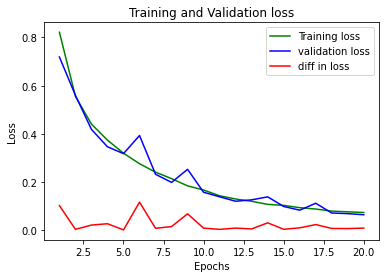

In [287]:
# Code to create graph for train vs validation error for different epochs

loss_train = history.history['loss']
loss_val = history.history['val_loss']

diff_in_loss=abs(np.subtract(loss_val,loss_train));

df = pd.DataFrame({'loss_train':loss_train, 'loss_val':loss_val, 'diff_in_loss':diff_in_loss})

print(df.head(10))

epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.plot(epochs, diff_in_loss, 'r', label='diff in loss')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

timeStr=datetime.now().strftime("%Y%m%d-%H%M%S");
fileName = 'train_vs_Validation_loss_'+timeStr

plt.savefig(fileName+'.png',format='png', dpi=2000)
plt.savefig(fileName+'.jpg',format='jpg', dpi=2000)

df.to_excel("neural_network_train_vs_val_loss"+timeStr+".xlsx", sheet_name='TrainvsValLoss')

plt.show()

In [297]:
#Predict results 
#predict_results = model.predict(X_test,y_test)
#predict_results = predict_results.argmax(axis=1)
#np.any(predict_results)

In [307]:
#Hyperparameter Tuning to Tune Optimization Algorithm

from sklearn.model_selection import GridSearchCV

# create model
#model = KerasRegressor(build_fn=get_nn_simplemodel, n_inputs=len(X.columns), epochs=100, batch_size=50, n_outputs=1, verbose=0)
model = KerasClassifier(build_fn=getmodel, n_inputs=len(F.columns), epochs=100, batch_size=50, n_outputs=3,verbose=0)

# define the grid search parameters
optimizer = ['RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizerinput=optimizer)
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
  
    

NameError: name 'StratifiedKFold' is not defined

InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [50,3] and labels shape [150]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at C:\Users\Admin\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765) ]] [Op:__inference_train_function_69359]

Function call stack:
train_function


In [103]:
# Investigating the distr of all ys
#ax = sb.countplot(x = y_test, palette = "Set3")

In [ ]:
# Investigating the distr of all ys
#ax = sb.countplot(x = y_valid, palette = "Set3")

In [104]:
# Training my model

log_reg = LogisticRegression(random_state=40, solver = 'lbfgs')

log_reg.fit(X_train, y_train)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(random_state=40)

# **Model 1**

In [ ]:
# predict - Predict class labels for samples in X
#log_reg.predict(X_train)
#y_pred = log_reg.predict(X_train)

# predict_proba - Probability estimates
#pred_proba = log_reg.predict_proba(X_train)

# coef_ - Coefficient of the features in the decision function
#log_reg.coef_

In [ ]:
#Evaluating the model
# Accuracy on Train
#print("The Training Accuracy is: ", log_reg.score(X_train, y_train))

# Accuracy on Test
#print("The Testing Accuracy is: ", log_reg.score(X_test, y_test))


# Classification Report
#print(classification_report(y_train, y_pred))

In [ ]:
# Confusion Matrix function

#def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    #"""Plots a confusion matrix."""
    #if classes is not None:
        #sb.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
        #sb.set(rc={'figure.figsize':(13,4)})
    #else:
       # sns.heatmap(cm, vmin=0., vmax=1.)
   # plt.title(title)
   # plt.ylabel('True label')
   # plt.xlabel('Predicted label')

In [ ]:
# Visualizing cm

#cm = confusion_matrix(y_train, y_pred)
#cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

#plot_confusion_matrix(cm_norm, classes = log_reg.classes_, title='Confusion matrix')

# **Model 2**

In [191]:
 #dataset = df.values
X = all_activities.iloc[:, 1:13]
y=all_activities.iloc[:, 13:14]
    
# encode class values as integers
#from sklearn import preprocessing
#le = preprocessing.LabelEncoder()
#le.fit(y)
#list(le.classes_)
#le.transform(y)
    


In [206]:
# get the model
def get_nn_model_function(n_inputs, n_outputs):
    network = Sequential()
    #network.add(Dense(8, input_shape=(n_inputs,), activation='relu'))
    #network.add(Dense(8, input_shape=(n_inputs,), kernel_initializer='he_uniform', activation='relu'))
    network.add(Dense(n_inputs, input_shape=(n_inputs,), kernel_initializer='normal', activation='relu'))
    
    network.add(Dense(16, activation='relu'))
    network.add(Dense(6, activation='relu'))
    network.add(Dense(4, activation='relu'))
    network.add(Dense(n_outputs, activation='relu'))

    sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=True)
    network.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return network
print(X_train.shape[1]);
n_inputs  = X_train.shape[1]
n_outputs= 3

# get model
#nn_model = get_nn_model_function1(n_inputs, n_outputs)
nn_model = get_nn_model_function(n_inputs, n_outputs)

#tf.reshape(data, [25, 25])

12


In [171]:
# make a prediction
#row = [12.073593,-0.05878,-35.897777,-116.179632]
#row = [ 13.794414,1.233146,-12.978329,-39.639737]
#yhat = model.predict([row])
#print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

In [204]:
y.describe()

,Activity
count,3599
unique,3
top,1
freq,1200


In [207]:
#model=get_nn_simpleClassificationmodel(n_inputs=len(F.columns), n_outputs=3);
#history =model.fit(X_train, y_train, verbose=1, epochs=20, batch_size=20, validation_data=(X_valid, y_valid))


#Train the model
nn_model.fit(X_train, y_train, verbose=1, epochs=10)

Epoch 1/10


InvalidArgumentError:  Received a label value of -2 which is outside the valid range of [0, 3).  Label values: -1 1 0 0 0 0 1 0 -1 0 0 1 2 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0 0 0 -2 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-207-72f8ac27f2ab>:6) ]] [Op:__inference_train_function_46988]

Function call stack:
train_function


The predictions using NN are
[[0.000000 0.000000 0.000000]
 [0.000000 0.000000 0.000000]
 [0.247322 0.249420 0.239021]
 [0.042753 0.044405 0.032209]
 [0.557339 0.559572 0.552010]]


In [196]:
print(y.head)

<bound method NDFrame.head of      Activity
0           0
1           0
2           0
3           0
4           0
...       ...
3595        2
3596        2
3597        2
3598        2
3599        2

[3599 rows x 1 columns]>


In [197]:
# evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)

print(loss)
print(acc)


InvalidArgumentError:  Received a label value of -5 which is outside the valid range of [0, 3).  Label values: -2 0 0 -2 0 -5 0 0 0 3 -3 3 0 0 4 0 0 0 -2 0 1 0 0 -1 0 2 0 0 0 0 0 0
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-197-073d24bdb7ec>:2) ]] [Op:__inference_test_function_39239]

Function call stack:
test_function


# **Model 3**

In [189]:
#Converts the default float32 to float64
tf.keras.backend.set_floatx('float64') 
def get_nn_model_function1(n_inputs, n_outputs):
    nn_model = Sequential()

    nn_model.add(tf.keras.layers.Dense(2000, activation='relu'))
    nn_model.add(tf.keras.layers.Dense(1000, activation='relu'))
    nn_model.add(tf.keras.layers.Dense(1500, activation='relu'))
    nn_model.add(tf.keras.layers.Dense(1, activation='softmax'))

    sgd = SGD(learning_rate=0.01, momentum=0.0, nesterov=True)
    nn_model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return nn_model

print(X_train.shape[1]);
n_inputs  = X_train.shape[1]
n_outputs= 1

# get model
nn_model = get_nn_model_function1(n_inputs, n_outputs)

#Prediction
y_pred = nn_model.predict(X_train)
y_pred

12


array([[1.000000],
       [1.000000],
       [1.000000],
       ...,
       [1.000000],
       [1.000000],
       [1.000000]])